## IMPORTS

In [12]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
MODEL_NAME = "ResNet50"
DATA_DIR = "images"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

## LOADING DATA

In [3]:
# Loading the training data

## Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

## We are loading the data from the directory using the generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 6039 images belonging to 2 classes.


In [4]:
# Loading the valdiation data

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 1707 images belonging to 2 classes.


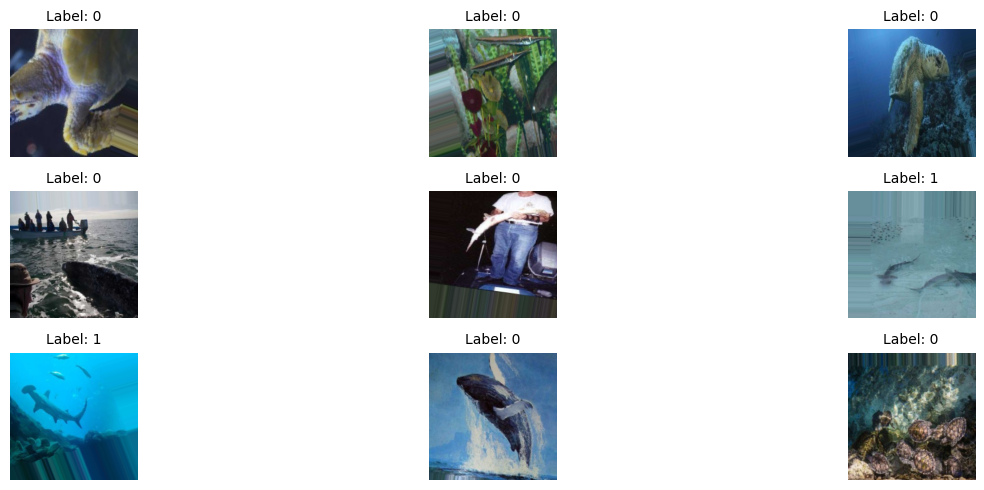

In [5]:
# Plotting few images

## Getting one batch of images and labels from the train_generator
images, labels = next(train_generator)

## Selecting 5 images to show
num_images = 3

## Set up the plot
fig, axes = plt.subplots(num_images, num_images, figsize=(15, 5))

## Loop through the grid and plot images
for i in range(num_images * num_images):
    row = i // num_images
    col = i % num_images
    
    ax = axes[row, col]
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f"Label: {int(labels[i])}", fontsize=10)

## Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## MODEL

In [6]:
# Creating the model

def get_model():
    
    # Getting the model to start transfer learning
    base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))

    # Freeze the pre-trained layers
    base_model.trainable = False

        # Custom classification head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid")  # Use 'softmax' for multi-class
    ])

    return model

In [7]:
# Creating callbacks

# Early Stopping Callback: Stops training if validation loss does not improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,           
    restore_best_weights=True
)

# Learning Rate Scheduler: Reduce LR when validation loss stops improving
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  
    factor=0.5,          
    patience=3,          
    min_lr=1e-6          
)


In [8]:
# Loading and compiling the model

model = get_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [9]:
# Training the model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler],
)

Epoch 1/10
189/189 [==============================] - 346s 2s/step - loss: 0.6547 - accuracy: 0.6234 - val_loss: 0.6110 - val_accuracy: 0.7088 - lr: 0.0010
Epoch 2/10
189/189 [==============================] - 319s 2s/step - loss: 0.6269 - accuracy: 0.6415 - val_loss: 0.6098 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 3/10
189/189 [==============================] - 321s 2s/step - loss: 0.6238 - accuracy: 0.6392 - val_loss: 0.5922 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 4/10
189/189 [==============================] - 317s 2s/step - loss: 0.6175 - accuracy: 0.6440 - val_loss: 0.5958 - val_accuracy: 0.6749 - lr: 0.0010
Epoch 5/10
189/189 [==============================] - 315s 2s/step - loss: 0.6128 - accuracy: 0.6600 - val_loss: 0.5987 - val_accuracy: 0.7147 - lr: 0.0010
Epoch 6/10
189/189 [==============================] - 316s 2s/step - loss: 0.6106 - accuracy: 0.6604 - val_loss: 0.5891 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 7/10
189/189 [==============================] - 335s 2s/st

In [ ]:
# Plotting training history

plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [10]:
model.save_weights("transfer_model_weights.h5")

In [ ]:
model.load_weights("transfer_model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
test_filenames = os.listdir("./images/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [18]:
batch_size = 15
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./images/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1943 validated image filenames.


In [21]:
import numpy as np
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\odonn\AppData\Local\Temp\ipykernel_26544\190903708.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [22]:
test_df['category'] = np.argmax(predict, axis=-1)

In [23]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [24]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

category
no_shark    1943
Name: count, dtype: int64


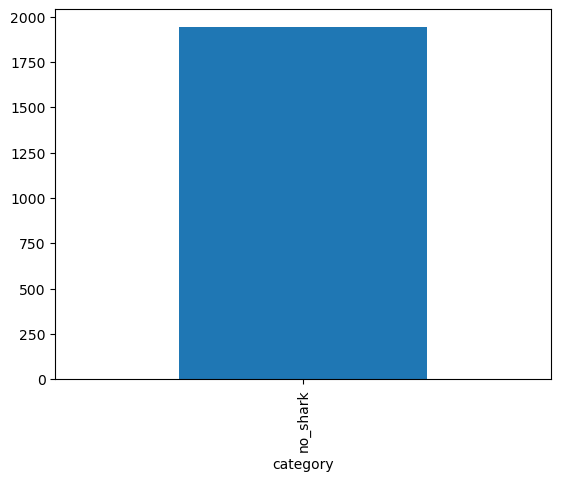

In [26]:
test_df['category'].value_counts().plot.bar()
print(test_df['category'].value_counts())

In [27]:
shark_correct = 0
shark_fp = 0
shark_total = 0
non_shark_correct = 0
non_shark_fp = 0
non_shark_total = 0
for i in range(len(test_df['category'])):
    # Predicted shark correctly
    if test_df['filename'][i].split('.')[0] in ('great_white_shark', 'hammerhead', 'tiger_shark') and test_df['category'][i] == 'shark':
        shark_correct += 1
        shark_total += 1
    elif test_df['filename'][i].split('.')[0] in ('great_white_shark', 'hammerhead', 'tiger_shark') and test_df['category'][i] == 'non-shark':
        shark_fp += 1
        shark_total += 1
    elif test_df['filename'][i].split('.')[0] not in ('great_white_shark', 'hammerhead', 'tiger_shark') and test_df['category'][i] == 'non-shark':
        non_shark_correct += 1
        non_shark_total += 1
    else:
        non_shark_fp += 1
        non_shark_total += 1

print('Sharks:', round(shark_correct/shark_total, 3) * 100, '%', sep='')
print('Non-sharks:', round(non_shark_correct/non_shark_total, 3) * 100)
print('Total:', round((shark_correct+non_shark_correct)/(shark_total+non_shark_total), 3) * 100)
print('')
tp = shark_correct + non_shark_correct
precision = tp / (tp + shark_fp)
recall = tp / (tp + non_shark_fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f'f1 score: {f1}')

ZeroDivisionError: division by zero